In [3150]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import io

from src.utils.figure import plot_lines
from src.utils.file import get_data_file_path
from src.utils.file import get_evaluation_file_path
from src.utils.metrics import metrics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Presentation

In [3151]:
presentation_row = 150
path = get_data_file_path(event_n=3, formula_n=3, count=2000)
data = pd.read_csv(path)

FileNotFoundError: [Errno 2] No such file or directory: './results/data/2000_3_events_3_formula_len.csv'

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
# Context
print(data.loc[presentation_row, 'context'])

In [ ]:
# Query 
print(data.loc[presentation_row, 'query'])

In [ ]:
# Question
print(data.loc[presentation_row, 'question'])

In [ ]:
# Code
print(data.loc[presentation_row, 'code'])

In [ ]:
# Formula
print(data.loc[presentation_row, 'formula'])

In [ ]:
# Plot Graph
graph = nx.read_graphml(io.StringIO(data.loc[presentation_row, 'graph']))
plt.figure(figsize=(6, 3))
plt.xlim(-1.35,1.35)
plt.ylim(-0.5,1.5)
pos = {"event1": (0, 1), "event2": (1, 0), "event3": (-1,0)}
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue')
plt.show()

In [ ]:
# Answer
print(data.loc[presentation_row, 'answer'])

# Prediction Presentation


In [ ]:
path = get_evaluation_file_path(event_n=3, formula_n=3, count=2000, model="gpt-3.5-turbo")
data = pd.read_csv(path)

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data['answer'] = data['answer'].apply(lambda x: 1 if x else 0)
data['prediction'] = data['prediction'].astype(int)

In [ ]:
# Accuracy
print(f'{len(data[data['answer'] == data['prediction']]) * 100 / len(data)}%')

In [ ]:
# Prediction Distribution
data['prediction'].value_counts()

In [ ]:
# Precision, Recall, F1
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(data['answer'], data['prediction'], average='macro')
recall = recall_score(data['answer'], data['prediction'], average='macro')
f1 = f1_score(data['answer'], data['prediction'], average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

# LLMs Evaluation

## 1. Event 3, Formula 3, Count 2000

In [ ]:
models = ["gpt-3.5-turbo", "llama3:70b-instruct", "qwen:72b-chat", "gemma:7b-instruct", "qwen:7b-chat",
          "mistral:7b-instruct"]

In [ ]:
models_metrics = {}
for model in models:
    path = get_evaluation_file_path(event_n=3, formula_n=3, count=2000, model=model)
    if not os.path.exists(path):
        warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
        continue
    data = pd.read_csv(path)
    data['answer'] = data['answer'].apply(lambda x: 1 if x else 0)
    data['prediction'] = data['prediction'].astype(int)
    models_metrics[model] = metrics(data)['raw']

df = pd.DataFrame(models_metrics)
df.transpose()

In [ ]:
# large models mean
df.transpose().loc[['gpt-3.5-turbo', 'llama3:70b-instruct', 'qwen:72b-chat']].mean()

In [ ]:
# small models mean
df.transpose().loc[['gemma:7b-instruct', 'qwen:7b-chat', 'mistral:7b-instruct']].mean()

## 2. Event 2, Formula 1-9, Count 300

In [ ]:
event_n = 2
count = 300
formulas = [1, 2, 3, 4, 5, 7, 9]

models_data_df = pd.DataFrame()
for model in models:
    data = {}
    for formula_n in formulas:
        path = get_evaluation_file_path(event_n=event_n, formula_n=formula_n, count=count, model=model)
        if not os.path.exists(path):
            warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
            continue
        df = pd.read_csv(path)
        df['answer'] = df['answer'].apply(lambda x: 1 if x else 0)
        df['prediction'] = df['prediction'].astype(int)
        data[formula_n] = metrics(df)['raw']
    df = pd.DataFrame(data).transpose().reset_index().rename(columns={'index': 'number_of_operators'})
    df['model'] = model
    models_data_df = pd.concat([models_data_df, df], ignore_index=True)

models_data_df

### 2.1. Accuracy

In [ ]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='accuracy', z='model', title='Accuracy', x_label='Number of Operators',
           y_label='Accuracy', x_ticks=x_ticks, y_ticks=y_ticks)

### 2.2. Precision

In [ ]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='precision', z='model', title='Precision', x_label='Number of Operators',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

### 2.3. Recall

In [3152]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='recall', z='model', title='Recall', x_label='Number of Operators',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

KeyError: 'number_of_operators'

<Figure size 1600x500 with 0 Axes>

### 2.4. F1

In [ ]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.45, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='f1', z='model', title='F1', x_label='Number of Operators', y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

### 2.5. AUC

In [3153]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='auc', z='model', title='AUC', x_label='Number of Operators', y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

KeyError: 'number_of_operators'

<Figure size 1600x500 with 0 Axes>

## 3. Formula 2, Event 2-9, Count 300

In [3154]:
count = 300
formulas = 2
events_n = [2, 3, 4, 5, 7, 9]

models_data_df = pd.DataFrame()
for model in models:
    data = {}
    for e_n in events_n:
        path = get_evaluation_file_path(event_n=e_n, formula_n=formulas, count=count, model=model)
        if not os.path.exists(path):
            warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
            continue
        df = pd.read_csv(path)
        df['answer'] = df['answer'].apply(lambda x: 1 if x else 0)
        df['prediction'] = df['prediction'].astype(int)
        data[e_n] = metrics(df)['raw']
    df = pd.DataFrame(data).transpose().reset_index().rename(columns={'index': 'number_of_events'})
    df['model'] = model
    models_data_df = pd.concat([models_data_df, df], ignore_index=True)

models_data_df

/var/folders/ll/1lnz2h617zj3ztl0jnrd5h7w0000gn/T/ipykernel_23937/1323746287.py:11: UserWarning: Evaluation file of model gpt-3.5-turbo does not exist.
  warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
/var/folders/ll/1lnz2h617zj3ztl0jnrd5h7w0000gn/T/ipykernel_23937/1323746287.py:11: UserWarning: Evaluation file of model llama3:70b-instruct does not exist.
  warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
/var/folders/ll/1lnz2h617zj3ztl0jnrd5h7w0000gn/T/ipykernel_23937/1323746287.py:11: UserWarning: Evaluation file of model qwen:72b-chat does not exist.
  warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
/var/folders/ll/1lnz2h617zj3ztl0jnrd5h7w0000gn/T/ipykernel_23937/1323746287.py:11: UserWarning: Evaluation file of model gemma:7b-instruct does not exist.
  warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
/var/folders/ll/1lnz2h617zj3ztl0jnrd5h7w0000gn/T/ipykernel

,number_of_events,model


### 3.1. Accuracy

/Users/weizhitang/Local/Research/LTL-Evaluation-Benchmark/src/utils/figure.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


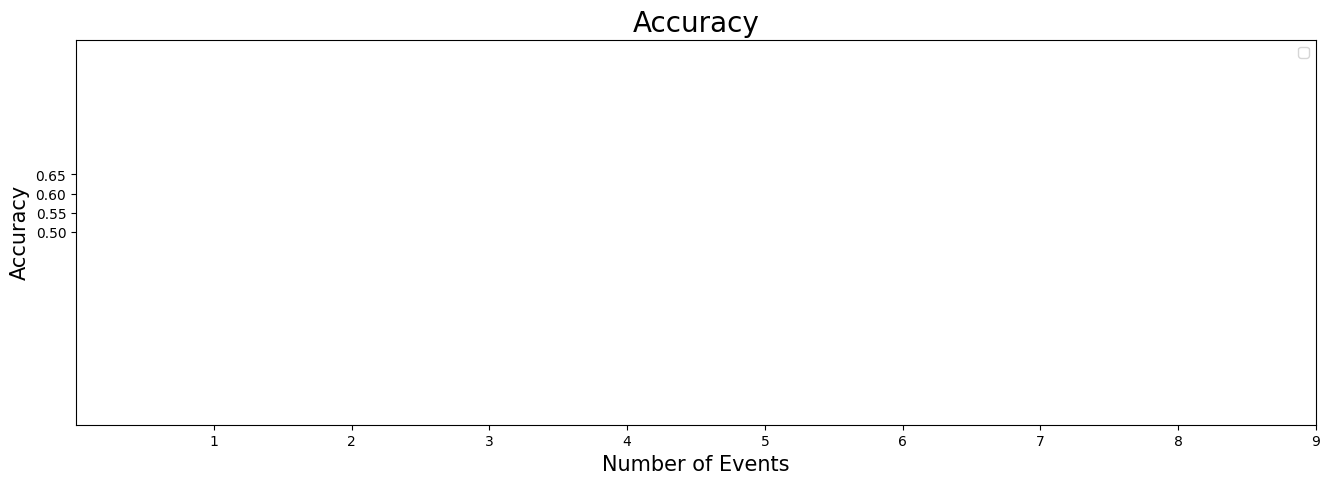

In [3155]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='accuracy', z='model', title='Accuracy', x_label='Number of Events',
           y_label='Accuracy', x_ticks=x_ticks, y_ticks=y_ticks)

### 3.2. Precision

/Users/weizhitang/Local/Research/LTL-Evaluation-Benchmark/src/utils/figure.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


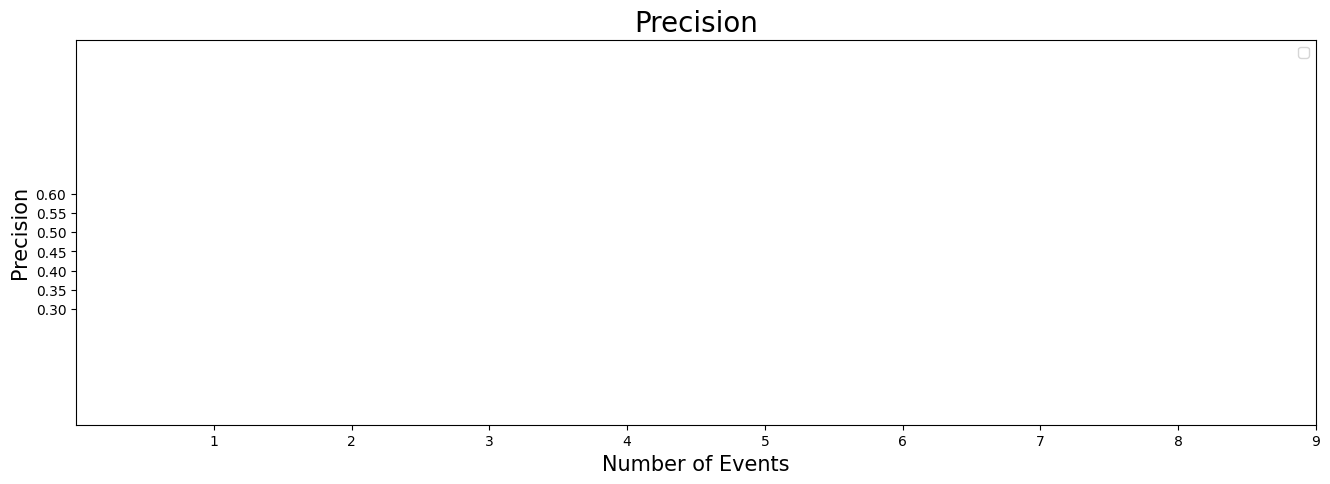

In [3156]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.3, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='precision', z='model', title='Precision', x_label='Number of Events',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

### 3.3. Recall

/Users/weizhitang/Local/Research/LTL-Evaluation-Benchmark/src/utils/figure.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


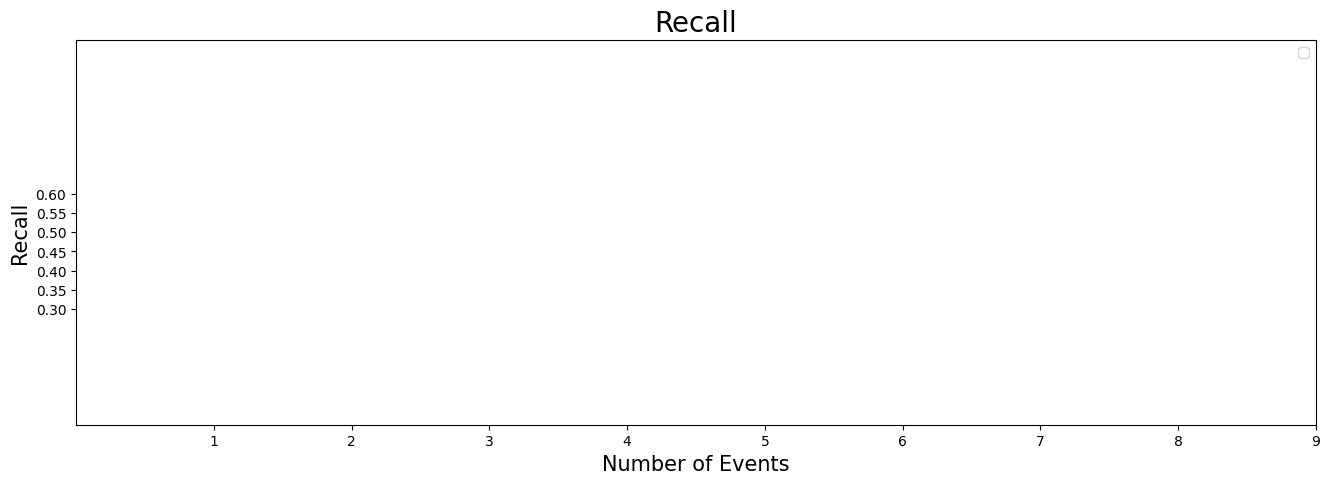

In [3157]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.3, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='recall', z='model', title='Recall', x_label='Number of Events',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

### 3.4. F1

/Users/weizhitang/Local/Research/LTL-Evaluation-Benchmark/src/utils/figure.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


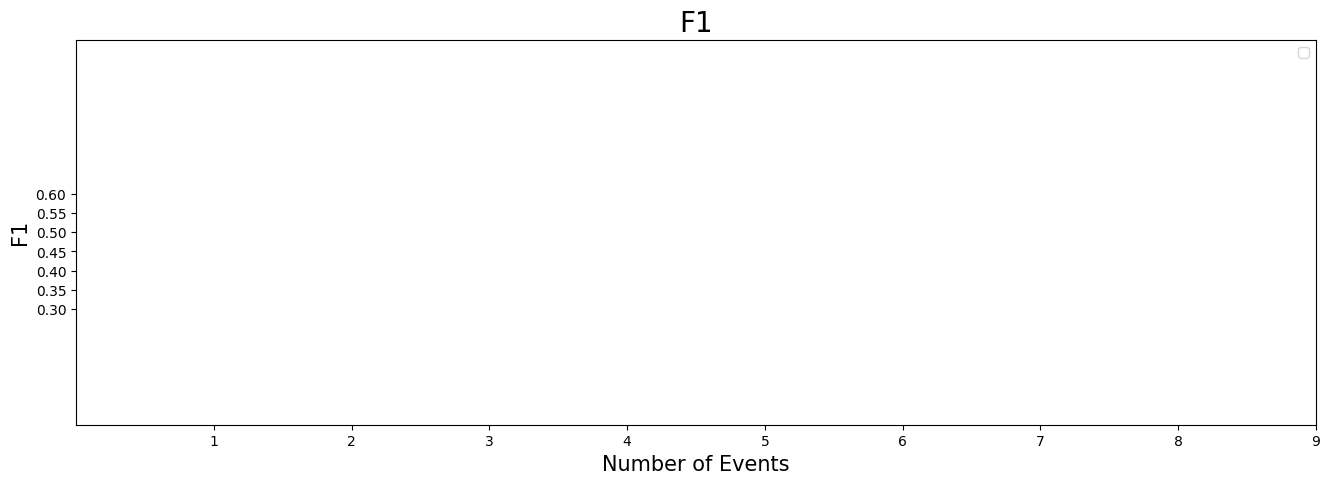

In [3158]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.3, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='f1', z='model', title='F1', x_label='Number of Events', y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

### 3.5. AUC

/Users/weizhitang/Local/Research/LTL-Evaluation-Benchmark/src/utils/figure.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


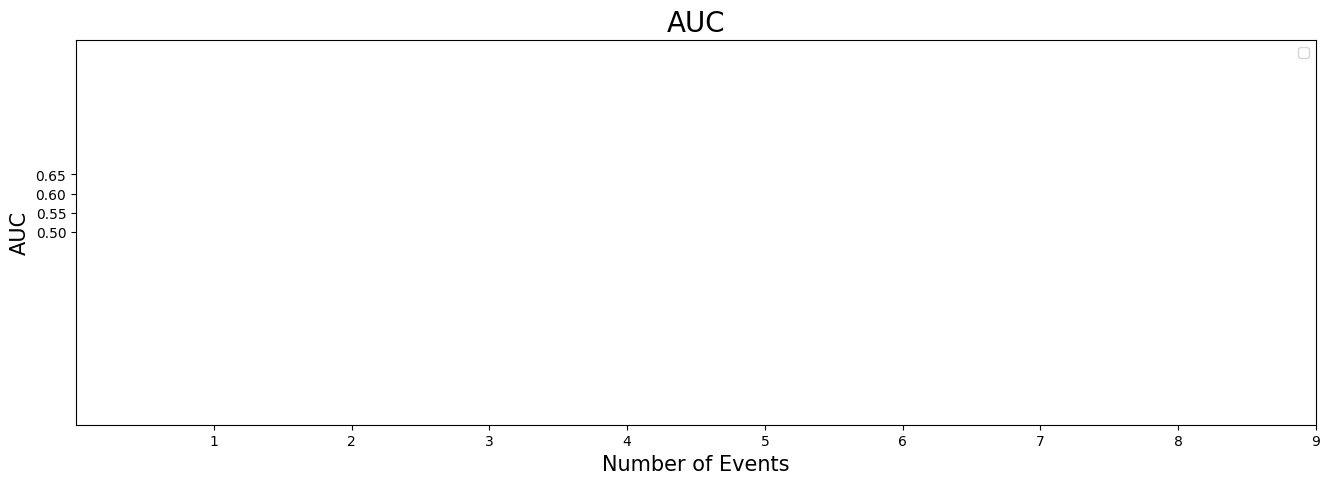

In [3159]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='auc', z='model', title='AUC', x_label='Number of Events', y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)